# Project Overview

## Scope
- Analyze multiple local CSV datasets to identify possible relationships and correlations.
- Automatically detect:
  - Schema similarities (column names/types)
  - Shared data or overlapping values
  - Entity links across datasets
  - Potential geographic or temporal relationships
- Designed for datasets like public records (e.g., crime reports, arrest logs).

## Functionality
- Load all CSV files from a specified local directory.
- Perform random sampling and lightweight profiling on each dataset.
- Use a locally hosted LLM (via Ollama API) to:
  - Interpret dataset structure and content
  - Suggest how datasets might relate
  - Propose possible joins, correlations, or common entities
- Print human-readable output with insights.
- Modular Jupyter Notebook format, broken into logical steps.

## Architecture & Design
- **Environment**: Jupyter Notebook with Python 3.x.
- **File Input**: Local CSV files in a defined directory.
- **Sampling**: Random subset per dataset to limit memory and improve performance.
- **Profiling**: Per-column metadata (types, unique counts, missing %, examples).
- **LLM Integration**:
  - Prompt built from samples and profiles
  - LLMs called via HTTP API (`http://localhost:11434/`)
  - Model is configurable (e.g., LLaMA3, Mistral)
- **Extensibility**: Designed to support future features like:
  - Visualization of relationships
  - Dataset joining
  - Output logging
  - Database integration


## Cell 1: Project Setup & Configuration

### Purpose
Initialize configuration variables and environment settings for the dataset analysis notebook. This includes setting:
- The path to the folder containing local CSV files
- Sampling and profiling parameters
- Ollama API connection details and LLM model selection

This cell prepares the foundation for all downstream steps.

---

### Inputs
None from the user at runtime, but the developer must:
- Set the `DATA_FOLDER` path (string): absolute path to the folder containing `.csv` files
- Set the `SAMPLE_SIZE` (int): how many rows to randomly sample per dataset
- Set the `SEED` (int): for reproducibility of sampling
- Set the `OLLAMA_API_URL` (string): URL where the Ollama service is listening (default `http://localhost:11434/`)
- Set the `LLM_MODEL` (string): model to be used via Ollama (e.g., `llama3.1:latest`)

---

### Outputs
- Global variables stored in the Jupyter notebook environment:
  - `DATA_FOLDER`
  - `SAMPLE_SIZE`
  - `SEED`
  - `OLLAMA_API_URL`
  - `LLM_MODEL`

- Print output confirming:
  - Directory being scanned
  - Number of rows to sample
  - Model and endpoint in use

---

### Behavior & Comments
- Include an introductory Markdown comment block in the cell explaining what this setup does.
- All variables should be defined clearly and separately, not embedded in function calls.
- Add inline comments for each configuration line to explain what it controls.
- Include `print()` statements to inform the user what values are being set and used.
- No external libraries are required in this cell.

---

### Extensibility Notes
- This cell may later include additional configuration for output logging, file filters (e.g., by filename keyword), or dataset limits.
- Ollama model names and endpoint URL should be easy to change from this one cell.



In [1]:
# ============================================
# Cell 1: Project Setup & Configuration
# ============================================
# This cell initializes the configuration for the dataset analysis project.
#
# INPUTS:
#   - Folder path to local CSV files
#   - Sample size for random row selection
#   - Random seed for reproducibility
#   - Ollama API endpoint and model name
#
# OUTPUTS:
#   - Variables available throughout the notebook:
#       DATA_FOLDER, SAMPLE_SIZE, SEED, OLLAMA_API_URL, LLM_MODEL
#   - Console output confirming the configuration

# Path to the folder containing your CSV datasets
DATA_FOLDER = "/m2-data/dataSets/csv"  

# Number of rows to sample from each dataset
SAMPLE_SIZE = 100

# Random seed for reproducibility
SEED = 42

# Ollama API endpoint URL
OLLAMA_API_URL = "http://localhost:11434"

# Name of the LLM model to use via Ollama
LLM_MODEL = "llama3.1:latest"

# Print configuration status
print("Configuration initialized:")
print(f"  Data folder: {DATA_FOLDER}")
print(f"  Sample size: {SAMPLE_SIZE} rows per dataset")
print(f"  Random seed: {SEED}")
print(f"  LLM model: {LLM_MODEL}")
print(f"  Ollama API URL: {OLLAMA_API_URL}")


Configuration initialized:
  Data folder: /m2-data/dataSets/csv
  Sample size: 100 rows per dataset
  Random seed: 42
  LLM model: llama3.1:latest
  Ollama API URL: http://localhost:11434


## Cell 2: Load CSV Files

### Purpose
Scan the specified local directory for CSV files and load each file into a pandas DataFrame. Store all loaded datasets in a dictionary for downstream processing.

---

### Inputs
- `DATA_FOLDER` (string): Path to the folder containing `.csv` files
- Assumes `pandas` is available

---

### Outputs
- `datasets` (dict): Mapping from filename to `pandas.DataFrame`
- Console output:
  - Number of files found and loaded
  - Number of rows and columns in each dataset
  - Warnings if any files fail to load

---

### Behavior & Comments
- Use `os.listdir()` to identify `.csv` files
- Use `pandas.read_csv()` to load each dataset
- Handle file loading errors with `try/except` and print useful messages
- All filenames used as keys in the dictionary should remain unmodified (no path stripping)
- Avoid loading non-CSV files even if present in the folder

---

### Extensibility Notes
- This cell could later support filtering by filename (e.g., wildcard or prefix)
- May be extended to support file size limits or preview mode
- Could be refactored into a reusable utility function if needed


In [2]:
# ============================================
# Cell 2: Load CSV Files
# ============================================
# This cell scans the specified folder for CSV files and loads each file into a pandas DataFrame.
#
# INPUT:
#   - DATA_FOLDER: Folder path defined in Cell 1.
#
# OUTPUT:
#   - datasets: Dictionary of {filename: DataFrame} for successfully loaded CSVs.
#   - Status messages printed to the console.

import os
import pandas as pd

# Initialize dictionary to hold datasets
datasets = {}

# List all files in the folder that end with ".csv" (case-insensitive)
print(f"Scanning folder for CSV files: {DATA_FOLDER}")
all_files = os.listdir(DATA_FOLDER)
csv_files = [f for f in all_files if f.lower().endswith(".csv")]

print(f"Found {len(csv_files)} CSV file(s):")
for f in csv_files:
    print(f"  - {f}")

# Load each CSV file into a pandas DataFrame
for fname in csv_files:
    file_path = os.path.join(DATA_FOLDER, fname)
    print(f"Loading file: {fname}")
    try:
        df = pd.read_csv(file_path)
        datasets[fname] = df
        print(f"  Successfully loaded: {fname} ({df.shape[0]} rows, {df.shape[1]} columns)")
    except Exception as e:
        print(f"  Failed to load '{fname}'. Error: {e}")

# Summary
print(f"Finished loading. Successfully loaded {len(datasets)} of {len(csv_files)} file(s).")


Scanning folder for CSV files: /m2-data/dataSets/csv
Found 3 CSV file(s):
  - LA-Crime_Data_from_2020_to_Present.csv
  - LAPD_RIPA_STOP_Person_Detail_from_7_1_2018_to_Present.csv
  - Arrest_Data_from_2020_to_Present.csv
Loading file: LA-Crime_Data_from_2020_to_Present.csv
  Successfully loaded: LA-Crime_Data_from_2020_to_Present.csv (1005109 rows, 28 columns)
Loading file: LAPD_RIPA_STOP_Person_Detail_from_7_1_2018_to_Present.csv


/tmp/ipykernel_52897/2521258603.py:33: DtypeWarning: Columns (7,8,9,70,102,133,134) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


  Successfully loaded: LAPD_RIPA_STOP_Person_Detail_from_7_1_2018_to_Present.csv (3156443 rows, 135 columns)
Loading file: Arrest_Data_from_2020_to_Present.csv
  Successfully loaded: Arrest_Data_from_2020_to_Present.csv (342735 rows, 25 columns)
Finished loading. Successfully loaded 3 of 3 file(s).


## Cell 3: Sample and Profile Each Dataset

### Purpose
For each dataset loaded in the previous step:
- Randomly sample a subset of rows
- Generate lightweight profiling metadata for each column

This helps the LLM later reason about what each dataset contains and how they might relate.

---

### Inputs
- `datasets` (dict): Dictionary of DataFrames from Cell 2
- `SAMPLE_SIZE` (int): Number of rows to sample
- `SEED` (int): Random seed for reproducibility

---

### Outputs
- `samples_and_profiles` (dict): Dictionary containing, for each file:
  - `sample`: Sampled data (list of row dictionaries)
  - `profile`: Metadata per column including:
    - Data type
    - Percentage of missing values
    - Number of unique values
    - Sample values
    - Min/max values for numeric or datetime types
- Console output:
  - Confirmation of profiling per file
  - Warnings if sampling or profiling fails

---

### Behavior & Comments
- Use `DataFrame.sample()` to extract a random sample of rows
- Loop through each column and compute:
  - `dtype`, `isna().mean()`, `nunique()`
  - Top 5 distinct non-null values (for context)
  - `min()` and `max()` for numeric or datetime columns
- Wrap processing in try/except and print errors if encountered
- Keep profiling lightweight and fast
- Use status messages to indicate progress through datasets

---

### Extensibility Notes
- Could be extended to include full statistics (e.g., std dev, histogram bins)
- Sampling approach can be changed to stratified or head/tail sampling


In [3]:
# ============================================
# Cell 3: Sample and Profile Each Dataset
# ============================================
# This cell performs two tasks for each loaded dataset:
#   1. Randomly sample a number of rows for lightweight inspection
#   2. Generate profiling metadata for each column in the dataset
#
# INPUTS:
#   - datasets: Dictionary of {filename: DataFrame} from Cell 2
#   - SAMPLE_SIZE: Number of rows to sample from each dataset
#   - SEED: Random seed for reproducibility
#
# OUTPUT:
#   - samples_and_profiles: Dictionary where each key is a filename and the value is a dictionary with:
#       - 'sample': List of sampled row dicts (used for LLM prompt)
#       - 'profile': Metadata for each column (type, missing %, unique count, example values, min/max)

samples_and_profiles = {}

print("Beginning sampling and profiling for all datasets...")

for fname, df in datasets.items():
    print(f"Processing: {fname}")
    profile = {}

    try:
        # Ensure we don't sample more rows than exist in the dataset
        sample_count = min(SAMPLE_SIZE, len(df))
        
        # Randomly sample rows from the dataset
        sampled = df.sample(n=sample_count, random_state=SEED)

        # Iterate through each column to generate a profile
        for col in df.columns:
            series = df[col]
            col_profile = {
                "type": str(series.dtype),
                "missing_pct": round(series.isna().mean(), 4),
                "unique_vals": int(series.nunique(dropna=True)),
                "sample_values": series.dropna().unique()[:5].tolist()
            }

            # If column is numeric or datetime-like, capture min and max
            if pd.api.types.is_numeric_dtype(series) or pd.api.types.is_datetime64_any_dtype(series):
                col_profile["min"] = series.min()
                col_profile["max"] = series.max()

            profile[col] = col_profile

        # Store the sample and profile together
        samples_and_profiles[fname] = {
            "sample": sampled.head(5).to_dict(orient="records"),
            "profile": profile
        }

        print(f"  Sampled {sample_count} rows, profiled {len(profile)} columns")

    except Exception as e:
        print(f"  Warning: Failed to process '{fname}'. Error: {e}")

print("Completed profiling all datasets.")


Beginning sampling and profiling for all datasets...
Processing: LA-Crime_Data_from_2020_to_Present.csv
  Sampled 100 rows, profiled 28 columns
Processing: LAPD_RIPA_STOP_Person_Detail_from_7_1_2018_to_Present.csv
  Sampled 100 rows, profiled 135 columns
Processing: Arrest_Data_from_2020_to_Present.csv
  Sampled 100 rows, profiled 25 columns
Completed profiling all datasets.


## Cell 4: Generate Prompt and Query LLM

### Purpose
Construct a prompt from the profiling and sample data generated in Cell 3, then send this prompt to a locally running LLM via the Ollama API. The LLM should return insights about how the datasets may be related.

---

### Inputs
- `samples_and_profiles` (dict): Output from Cell 3, containing sampled rows and profiling metadata
- `OLLAMA_API_URL` (string): URL of the Ollama API (e.g., `http://localhost:11434`)
- `LLM_MODEL` (string): Name of the model to use with Ollama (e.g., `llama3.1:latest`)

---

### Outputs
- `llm_response` (string): Text response from the LLM
- Console output:
  - Notice when the prompt is constructed
  - Notice when the API call is made
  - Success or failure message after the API call
  - Final printed LLM response (summarized if long)

---

### Behavior & Comments
- Loop over each dataset in `samples_and_profiles`
  - Include dataset name, column metadata, and 3–5 sampled rows per file
- Format the full prompt as plain text (not JSON)
  - Use clean, readable formatting suitable for LLM interpretation
- Send the prompt to Ollama using HTTP POST to `/api/generate`
  - Use `requests` library to make the API call
  - POST body should include: `model`, `prompt`, and `stream: false`
- Check for and handle HTTP or JSON errors gracefully
- Print a status message after querying the LLM

---

### Extensibility Notes
- May support streaming output or function calling in future Ollama versions
- Could support prompt templates to standardize instructions
- Could be modified to log input/output pairs for auditing


In [4]:
# ============================================
# Cell 4: Generate Prompt and Query LLM
# ============================================
# This cell takes the output from Cell 3 (samples and profiling) and:
#   1. Constructs a plain text prompt for an LLM to analyze dataset relationships
#   2. Sends the prompt to a local Ollama model via its API
#   3. Prints the LLM's response, which includes insights about how the datasets may be related
#
# INPUTS:
#   - samples_and_profiles: Dictionary of {filename: {sample, profile}} from Cell 3
#   - OLLAMA_API_URL: Endpoint where Ollama is listening
#   - LLM_MODEL: The name of the LLM model to use via Ollama
#
# OUTPUT:
#   - llm_response: Text string containing the LLM's output
#   - Printed status and response to console

import requests
import json

def build_prompt(samples_and_profiles):
    """
    Builds a prompt for the LLM based on the dataset samples and profiles.
    The prompt is structured in plain text for natural interpretation by the LLM.
    """
    prompt = (
        "You are a data analyst AI. Your task is to analyze the following datasets "
        "to determine how they might be related. Identify potential joins, common entities, "
        "matching column names or types, overlapping values, and possible correlations.\n\n"
    )

    for fname, content in samples_and_profiles.items():
        prompt += f"Dataset: {fname}\n"
        prompt += "Columns and metadata:\n"
        for col, meta in content["profile"].items():
            prompt += (
                f"  - {col}: type={meta['type']}, unique={meta['unique_vals']}, "
                f"missing_pct={meta['missing_pct']}\n"
            )
        prompt += "Sample rows:\n"
        for row in content["sample"]:
            prompt += f"  {row}\n"
        prompt += "\n"

    prompt += (
        "Provide a summary of relationships between these datasets. "
        "Explain any shared fields, related concepts, and suggestions for analysis.\n"
    )
    return prompt

# Build the prompt from the profiling and sample data
print("Building prompt for LLM...")
prompt_text = build_prompt(samples_and_profiles)

# Prepare payload for Ollama API
payload = {
    "model": LLM_MODEL,
    "prompt": prompt_text,
    "stream": False
}

headers = {"Content-Type": "application/json"}

print("Sending prompt to LLM...")

try:
    response = requests.post(
        f"{OLLAMA_API_URL}/api/generate",
        headers=headers,
        data=json.dumps(payload)
    )
    response.raise_for_status()
    llm_response = response.json().get("response", "")

    print("LLM response received:")
    print("-" * 40)
    print(llm_response)
    print("-" * 40)

except requests.exceptions.RequestException as e:
    print(f"Error contacting LLM API: {e}")
    llm_response = ""

except (ValueError, KeyError) as e:
    print(f"Error parsing response from LLM: {e}")
    llm_response = ""


Building prompt for LLM...
Sending prompt to LLM...
LLM response received:
----------------------------------------
Based on the provided information, I've identified some key observations about the relationships between the datasets.

**Shared Fields:**

1. **Report ID**: A unique identifier for each report, which can be used to link data across different tables or datasets.
2. **Arrest Date**: The date of the arrest, which is a common field in both the "Booking" and "RFC" (Request for Custody) reports.
3. **Area ID** and **Area Name**: These fields indicate the location where the arrest occurred, which can be used to analyze crime patterns by neighborhood or district.
4. **Reporting District**: This field links to a specific police department or jurisdiction, which may have its own set of rules, regulations, and procedures for handling arrests.

**Related Concepts:**

1. **Booking Process**: The "Booking" dataset appears to contain information related to the initial processing of an 

## Cell 5: Compare Shared Fields Across Datasets

### Purpose
Identify and evaluate common column names across datasets, and assess how well their values align. This determines whether those fields can be used to relate or join datasets reliably.

---

### Inputs
- `datasets` (dict): Dictionary of DataFrames from Cell 2

---

### Outputs
- `field_comparisons` (dict): Nested dictionary where keys are dataset pairs and values are:
  - Shared column names
  - Overlap statistics for each shared field:
    - Total unique values per dataset
    - Number of overlapping values
    - Percent overlap (intersection / union)
    - Sample of overlapping and unique values
- Console output:
  - Dataset pairs being compared
  - Shared fields and summary of overlaps
  - Warnings or notes if no shared fields are found

---

### Behavior & Comments
- Compare all unique dataset pairs (e.g., A vs. B, B vs. C)
- For each pair, identify columns with exact name matches
- For each shared column:
  - Extract unique non-null values from both datasets
  - Compute intersection, union, and percent overlap
  - Select example overlapping and non-overlapping values
- Use print statements to log progress and key findings

---

### Extensibility Notes
- Can be extended to fuzzy-match column names (e.g., `AreaID` vs `area_id`)
- Could support data type matching checks (e.g., int vs. string)
- May be refactored into a utility function for reusability


In [5]:
# ============================================
# Cell 5: Compare Shared Fields Across Datasets
# ============================================
# This cell analyzes every unique pair of datasets to:
#   - Identify shared column names
#   - Compute the degree of overlap between values in those columns
#
# INPUT:
#   - datasets: Dictionary of {filename: DataFrame} from Cell 2
#
# OUTPUT:
#   - field_comparisons: Dictionary structured as:
#       {
#         (dataset1, dataset2): {
#             column_name: {
#                 "unique_in_dataset1": int,
#                 "unique_in_dataset2": int,
#                 "shared_values": int,
#                 "percent_overlap": float,
#                 "example_shared": list,
#                 "example_only_in_1": list,
#                 "example_only_in_2": list
#             },
#             ...
#         },
#         ...
#       }
#   - Console output summarizing shared fields and value overlap for each dataset pair

from itertools import combinations

field_comparisons = {}

print("Comparing shared fields across dataset pairs...")

# Generate all unique dataset pairs
dataset_names = list(datasets.keys())
for ds1, ds2 in combinations(dataset_names, 2):
    df1, df2 = datasets[ds1], datasets[ds2]
    shared_columns = set(df1.columns).intersection(df2.columns)

    print(f"\nAnalyzing: '{ds1}' vs. '{ds2}'")
    if not shared_columns:
        print("  No shared columns found.")
        continue

    pair_key = (ds1, ds2)
    field_comparisons[pair_key] = {}

    for col in shared_columns:
        print(f"  Comparing shared field: {col}")
        try:
            values1 = set(df1[col].dropna().unique())
            values2 = set(df2[col].dropna().unique())

            shared = values1.intersection(values2)
            union = values1.union(values2)

            result = {
                "unique_in_dataset1": len(values1),
                "unique_in_dataset2": len(values2),
                "shared_values": len(shared),
                "percent_overlap": round(len(shared) / len(union), 4) if union else 0.0,
                "example_shared": list(shared)[:5],
                "example_only_in_1": list(values1 - values2)[:5],
                "example_only_in_2": list(values2 - values1)[:5]
            }

            field_comparisons[pair_key][col] = result

            # Print summary for this column
            print(f"    Shared values: {result['shared_values']}")
            print(f"    Percent overlap: {result['percent_overlap'] * 100:.2f}%")

        except Exception as e:
            print(f"    Warning: Failed to compare column '{col}'. Error: {e}")

print("\nCompleted field comparison across all dataset pairs.")


Comparing shared fields across dataset pairs...

Analyzing: 'LA-Crime_Data_from_2020_to_Present.csv' vs. 'LAPD_RIPA_STOP_Person_Detail_from_7_1_2018_to_Present.csv'
  No shared columns found.

Analyzing: 'LA-Crime_Data_from_2020_to_Present.csv' vs. 'Arrest_Data_from_2020_to_Present.csv'
  Comparing shared field: LON
    Shared values: 4630
    Percent overlap: 92.75%
  Comparing shared field: LAT
    Shared values: 4853
    Percent overlap: 88.80%
  Comparing shared field: Cross Street
    Shared values: 6181
    Percent overlap: 44.22%

Analyzing: 'LAPD_RIPA_STOP_Person_Detail_from_7_1_2018_to_Present.csv' vs. 'Arrest_Data_from_2020_to_Present.csv'
  Comparing shared field: Area ID
    Shared values: 21
    Percent overlap: 95.45%
  Comparing shared field: Area Name
    Shared values: 16
    Percent overlap: 59.26%
  Comparing shared field: Reporting District
    Shared values: 1135
    Percent overlap: 88.46%

Completed field comparison across all dataset pairs.


## Cell 6: Fuzzy Match Column Names Across Datasets

### Purpose
Identify semantically similar column names across datasets that were not matched exactly. This expands the opportunity to detect relationships between datasets that use inconsistent naming conventions.

---

### Inputs
- `datasets` (dict): Dictionary of DataFrames from Cell 2

---

### Outputs
- `fuzzy_matches` (dict): Dictionary of {dataset pair: list of (column_from_A, column_from_B, similarity_score)}
- Console output:
  - Dataset pairs being compared
  - Likely column name matches based on a similarity threshold
  - Warnings or skips if there are too few columns

---

### Behavior & Comments
- Compare each dataset pair (e.g., A vs B) across all column names (not just exact matches)
- Use fuzzy string matching to compute similarity between column names
- Only retain matches above a threshold (e.g., 85%)
- Avoid redundant pairs (A vs B is same as B vs A)

Recommended matching method:
- Normalize column names (e.g., lowercase, strip spaces and symbols)
- Use `RapidFuzz` or `difflib` to compute similarity scores

---

### Extensibility Notes
- Could be enhanced with token-based or embedding-based matching (e.g., sentence transformers)
- May integrate results with value-level overlap to confirm semantic matches


In [6]:
# ============================================
# Cell 6: Fuzzy Match Column Names Across Datasets
# ============================================
# This cell identifies column names that are semantically similar but not exact matches,
# using fuzzy string matching to compare all column names between dataset pairs.
#
# INPUT:
#   - datasets: Dictionary of {filename: DataFrame} from Cell 2
#
# OUTPUT:
#   - fuzzy_matches: Dictionary of {(dataset1, dataset2): [ (col_A, col_B, score), ... ]}
#   - Printed matches with similarity scores above a defined threshold

from itertools import combinations
from rapidfuzz import fuzz

# Threshold for match confidence (adjustable)
SIMILARITY_THRESHOLD = 85

# Dictionary to hold match results
fuzzy_matches = {}

print("Running fuzzy column name matching across dataset pairs...")

dataset_names = list(datasets.keys())

for ds1, ds2 in combinations(dataset_names, 2):
    df1, df2 = datasets[ds1], datasets[ds2]
    columns1 = df1.columns
    columns2 = df2.columns

    matches = []

    print(f"\nComparing column names between '{ds1}' and '{ds2}'")

    for col1 in columns1:
        for col2 in columns2:
            # Normalize column names for better matching
            norm_col1 = col1.lower().replace(" ", "").replace("_", "")
            norm_col2 = col2.lower().replace(" ", "").replace("_", "")

            # Compute similarity score
            score = fuzz.ratio(norm_col1, norm_col2)

            if score >= SIMILARITY_THRESHOLD:
                matches.append((col1, col2, score))

    if matches:
        fuzzy_matches[(ds1, ds2)] = matches
        print("  Likely matches found:")
        for col1, col2, score in matches:
            print(f"    {col1}  <-->  {col2}  (Similarity: {score}%)")
    else:
        print("  No likely matches above threshold.")

print("\nCompleted fuzzy matching of column names.")


Running fuzzy column name matching across dataset pairs...

Comparing column names between 'LA-Crime_Data_from_2020_to_Present.csv' and 'LAPD_RIPA_STOP_Person_Detail_from_7_1_2018_to_Present.csv'
  Likely matches found:
    AREA NAME  <-->  Area Name  (Similarity: 100.0%)

Comparing column names between 'LA-Crime_Data_from_2020_to_Present.csv' and 'Arrest_Data_from_2020_to_Present.csv'
  Likely matches found:
    AREA NAME  <-->  Area Name  (Similarity: 100.0%)
    LOCATION  <-->  Location  (Similarity: 100.0%)
    Cross Street  <-->  Cross Street  (Similarity: 100.0%)
    LAT  <-->  LAT  (Similarity: 100.0%)
    LON  <-->  LON  (Similarity: 100.0%)

Comparing column names between 'LAPD_RIPA_STOP_Person_Detail_from_7_1_2018_to_Present.csv' and 'Arrest_Data_from_2020_to_Present.csv'
  Likely matches found:
    Reporting District  <-->  Reporting District  (Similarity: 100.0%)
    Area ID  <-->  Area ID  (Similarity: 100.0%)
    Area Name  <-->  Area Name  (Similarity: 100.0%)

Completed

## Cell 7: Feed Field Comparison Results to the LLM

### Purpose
Use the structured results from earlier shared field comparisons to prompt the LLM with:
- Verified shared columns between datasets
- Overlap metrics (% value overlap, example values)
- Names of datasets involved

Ask the LLM to:
- Suggest join strategies (inner, left, key field priorities)
- Identify high-value analytical opportunities across datasets
- Propose data quality or cleaning improvements

---

### Inputs
- `field_comparisons` (dict): Output from Cell 5, containing overlap analysis
- `OLLAMA_API_URL` (string): URL to Ollama service
- `LLM_MODEL` (string): Selected LLM model name

---

### Outputs
- `llm_field_analysis_response` (string): Response from the LLM with insights
- Console output:
  - Status messages for prompt creation and submission
  - Summary or full LLM response

---

### Behavior & Comments
- Format the prompt with plain English descriptions of shared fields and overlap percentages
- Present the data in a concise but readable structure
- Ask the LLM to recommend:
  - Join strategies
  - Interesting analytical paths
  - Possible data cleanup or normalization steps
- Handle API errors gracefully

---

### Extensibility Notes
- Can be extended to include value-level statistics, fuzzy match confidence, or schema metadata
- Could wrap prompt generation and call into a utility function for reuse


In [7]:
# ============================================
# Cell 7: Feed Field Comparison Results to the LLM
# ============================================
# This cell summarizes the validated field relationships between datasets and
# sends them to the LLM for guidance on join strategies and analysis opportunities.
#
# INPUT:
#   - field_comparisons: Dictionary from Cell 5 with shared field overlap data
#   - OLLAMA_API_URL: The Ollama API endpoint
#   - LLM_MODEL: The selected model to query
#
# OUTPUT:
#   - llm_field_analysis_response: Text response from the LLM
#   - Printed output summarizing insights from the model

import requests
import json

def build_field_analysis_prompt(field_comparisons):
    """
    Creates a prompt summarizing shared fields and their overlap stats.
    This helps the LLM reason about possible joins and further analysis.
    """
    prompt = (
        "You are a data analysis assistant. Based on the following verified field-level comparisons "
        "between datasets, suggest how they might be joined or analyzed together.\n\n"
        "For each dataset pair, shared fields, value overlaps, and examples are provided.\n"
        "Please recommend join strategies, potential analytical directions, and data quality observations.\n\n"
    )

    for (ds1, ds2), fields in field_comparisons.items():
        prompt += f"Dataset Pair: '{ds1}' and '{ds2}'\n"
        for col, stats in fields.items():
            prompt += (
                f"  Shared Field: {col}\n"
                f"    - Unique in {ds1}: {stats['unique_in_dataset1']}\n"
                f"    - Unique in {ds2}: {stats['unique_in_dataset2']}\n"
                f"    - Shared values: {stats['shared_values']}\n"
                f"    - Percent overlap: {stats['percent_overlap'] * 100:.2f}%\n"
                f"    - Example shared values: {stats['example_shared']}\n"
            )
        prompt += "\n"

    prompt += (
        "Based on this data, which datasets should be joined and on what fields? "
        "What further analysis could be done across them? Are there any issues to address first?\n"
    )

    return prompt

# Build the prompt
print("Building prompt for LLM based on field comparison data...")
analysis_prompt = build_field_analysis_prompt(field_comparisons)

# Create the request payload
payload = {
    "model": LLM_MODEL,
    "prompt": analysis_prompt,
    "stream": False
}

headers = {"Content-Type": "application/json"}

print("Sending prompt to LLM...")

try:
    response = requests.post(
        f"{OLLAMA_API_URL}/api/generate",
        headers=headers,
        data=json.dumps(payload)
    )
    response.raise_for_status()
    llm_field_analysis_response = response.json().get("response", "")

    print("\nLLM response received:")
    print("-" * 40)
    print(llm_field_analysis_response)
    print("-" * 40)

except requests.exceptions.RequestException as e:
    print(f"Error contacting LLM API: {e}")
    llm_field_analysis_response = ""

except (ValueError, KeyError) as e:
    print(f"Error parsing response from LLM: {e}")
    llm_field_analysis_response = ""


Building prompt for LLM based on field comparison data...
Sending prompt to LLM...

LLM response received:
----------------------------------------
**Join Strategies and Recommendations**

1. **LA-Crime_Data_from_2020_to_Present.csv** and **Arrest_Data_from_2020_to_Present.csv**
	* Join on both `LON` ( longitude ) and `LAT` ( latitude ) fields to create a spatial join, allowing for geographic-based analysis.
	* Use an inner join with the shared values in `Cross Street` as a potential additional filter or analysis field.
2. **LAPD_RIPA_STOP_Person_Detail_from_7_1_2018_to_Present.csv** and **Arrest_Data_from_2020_to_Present.csv**
	* Join on the `Area ID` field, considering its high overlap (95.45%).
	* Use an inner join with additional fields like `Reporting District` to explore relationships between areas and arrest data.

**Potential Analytical Directions**

1. **Crime and Arrest Analysis**
	* Investigate spatial correlations between crime rates and arrest frequencies in different regi

## Cell 8 (Revised): Aggregate Datasets Before Join

### Purpose
Instead of joining full datasets at the row level (which can result in massive many-to-many joins), this cell performs group-level aggregation on the shared join keys. This provides a safe, scalable way to correlate datasets across spatial and geographic dimensions.

---

### Inputs
- `datasets` (dict): Loaded DataFrames from Cell 2
- Join keys:
  - Crime–Arrest: `['LAT', 'LON', 'Cross Street']`
  - RIPA–Arrest: `['Area ID', 'Area Name', 'Reporting District']`

---

### Outputs
- `agg_crime`: Aggregated crime data grouped by spatial keys
- `agg_arrests_for_crime`: Aggregated arrest data on the same spatial keys
- `agg_ripa`: Aggregated RIPA data grouped by geographic keys
- `agg_arrests_for_ripa`: Aggregated arrest data on the same geographic keys
- Merged summary tables:
  - `crime_arrest_summary`
  - `ripa_arrest_summary`
- Console output:
  - Row counts per group
  - Sample previews

---

### Behavior & Comments
- Normalize key fields for matching (lowercase, trimmed)
- Group each dataset by its relevant key fields
- Compute basic aggregates:
  - Record count per group (e.g., `crime_count`, `arrest_count`, `ripa_count`)
- Merge aggregated groups using inner join on shared keys
- Print resulting row counts and preview

---

### Extensibility Notes
- Aggregates can be expanded to include averages, top values, date ranges, etc.
- Can add geospatial grouping or time-based aggregation later
- Suitable for statistical comparison or visualization


In [11]:
# ============================================
# Cell 8 (Revised v2): Aggregate Datasets Before Join (Excluding Invalid Geocoordinates)
# ============================================
# This version filters out rows where LAT and LON are both zero before aggregation,
# preventing invalid groupings and false spatial overlaps.

# Helper to normalize string columns
def normalize_column(df, col):
    if col in df.columns and pd.api.types.is_string_dtype(df[col]):
        df[col] = df[col].astype(str).str.strip().str.lower()
    return df

# Dataset references
crime_df = datasets.get("LA-Crime_Data_from_2020_to_Present.csv")
arrest_df = datasets.get("Arrest_Data_from_2020_to_Present.csv")
ripa_df = datasets.get("LAPD_RIPA_STOP_Person_Detail_from_7_1_2018_to_Present.csv")

# --- Join 1: Crime + Arrest (Spatial) ---
spatial_keys = ['LAT', 'LON', 'Cross Street']
print("\nAggregating Crime and Arrest datasets on spatial fields (excluding invalid coordinates)...")

# Normalize columns
for col in spatial_keys:
    crime_df = normalize_column(crime_df, col)
    arrest_df = normalize_column(arrest_df, col)

# Exclude rows where both LAT and LON are zero
def filter_invalid_coords(df):
    if 'LAT' in df.columns and 'LON' in df.columns:
        return df[~((df['LAT'] == 0.0) & (df['LON'] == 0.0))]
    return df

crime_df_filtered = filter_invalid_coords(crime_df)
arrest_df_filtered = filter_invalid_coords(arrest_df)

if all(col in crime_df_filtered.columns and col in arrest_df_filtered.columns for col in spatial_keys):
    agg_crime = crime_df_filtered.groupby(spatial_keys).size().reset_index(name='crime_count')
    agg_arrests_for_crime = arrest_df_filtered.groupby(spatial_keys).size().reset_index(name='arrest_count')

    crime_arrest_summary = pd.merge(
        agg_crime,
        agg_arrests_for_crime,
        on=spatial_keys,
        how='inner'
    )

    print(f"Filtered crime records: {len(crime_df_filtered)}")
    print(f"Filtered arrest records: {len(arrest_df_filtered)}")
    print(f"Combined summary table (valid coordinates): {len(crime_arrest_summary)} rows")
    display(crime_arrest_summary.head(10))
else:
    print("One or more spatial join fields are missing. Skipping this aggregation.")
    crime_arrest_summary = None

# --- Join 2: RIPA + Arrest (Geographic) ---
geo_keys = ['Area ID', 'Area Name', 'Reporting District']
print("\nAggregating RIPA and Arrest datasets on geographic fields...")

# Normalize columns
for col in geo_keys:
    ripa_df = normalize_column(ripa_df, col)
    arrest_df = normalize_column(arrest_df, col)

if all(col in ripa_df.columns and col in arrest_df.columns for col in geo_keys):
    agg_ripa = ripa_df.groupby(geo_keys).size().reset_index(name='ripa_count')
    agg_arrests_for_ripa = arrest_df.groupby(geo_keys).size().reset_index(name='arrest_count')

    ripa_arrest_summary = pd.merge(
        agg_ripa,
        agg_arrests_for_ripa,
        on=geo_keys,
        how='inner'
    )

    print(f"Aggregated RIPA records: {len(agg_ripa)}")
    print(f"Aggregated arrest records: {len(agg_arrests_for_ripa)}")
    print(f"Combined summary table: {len(ripa_arrest_summary)} rows")
    display(ripa_arrest_summary.head(10))
else:
    print("One or more geographic join fields are missing. Skipping this aggregation.")
    ripa_arrest_summary = None



Aggregating Crime and Arrest datasets on spatial fields (excluding invalid coordinates)...
Filtered crime records: 1002869
Filtered arrest records: 338101
Combined summary table (valid coordinates): 27072 rows


,LAT,LON,Cross Street,crime_count,arrest_count
0,33.7065,-118.2929,PASEO DEL MAR,2,2
1,33.7068,-118.2929,GAFFEY,2,1
2,33.7068,-118.2929,GAFFEY ST,2,1
3,33.7070,-118.2879,SHEPARD ST,1,2
4,33.7079,-118.2879,40TH ST,1,1
5,33.7096,-118.2879,PACIFIC AV,2,3
6,33.7108,-118.2985,PASEO DEL MAR,2,1
7,33.7115,-118.2928,36TH ST,2,1
8,33.7115,-118.2879,36TH,1,1
9,33.7115,-118.2879,STEPHEN M WHITE,1,1



Aggregating RIPA and Arrest datasets on geographic fields...
Aggregated RIPA records: 1136
Aggregated arrest records: 1282
Combined summary table: 880 rows


,Area ID,Area Name,Reporting District,ripa_count,arrest_count
0,1,central,101,2404,235
1,1,central,105,409,78
2,1,central,109,147,48
3,1,central,111,8232,852
4,1,central,112,1164,136
5,1,central,118,2487,374
6,1,central,119,14389,3237
7,1,central,121,569,109
8,1,central,122,929,107
9,1,central,123,1523,272


## Cell 9: Correlation Analysis and Visualizations

### Purpose
Analyze the relationship between crime, arrest, and stop counts in the aggregated summary datasets.

---

### Inputs
- `crime_arrest_summary` (DataFrame): Grouped by ['LAT', 'LON', 'Cross Street']
- `ripa_arrest_summary` (DataFrame): Grouped by ['Area ID', 'Area Name', 'Reporting District']

---

### Outputs
- Printed correlation coefficients between count columns
- Scatter plots:
  - Crime vs Arrest counts (spatial)
  - RIPA vs Arrest counts (geographic)
- Optional bar plots (e.g., top locations by combined count)

---

### Behavior & Comments
- Use Pearson and Spearman correlation coefficients to detect linear and rank-based relationships
- Use scatter plots to visualize count distributions
- Log messages to indicate correlation values and plot success

---

### Extensibility Notes
- Can include ratio columns (e.g., arrest/crime or arrest/stop)
- May include map-based visualizations (e.g., with folium or geopandas)
- Could compute statistical significance if needed



Crime vs Arrest (spatial):
  Pearson correlation: 0.4512
  Spearman correlation: 0.4114


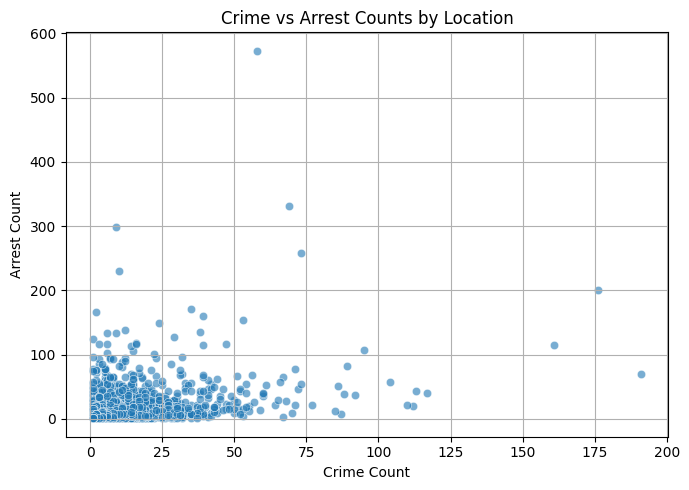


RIPA vs Arrest (geographic):
  Pearson correlation: 0.6844
  Spearman correlation: 0.7880


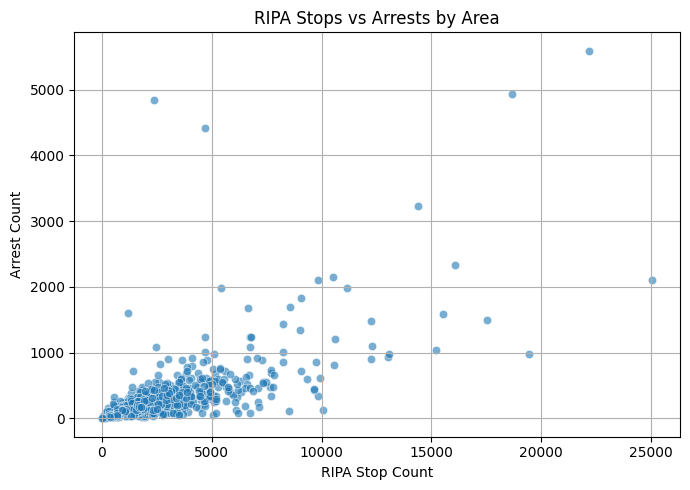

In [14]:
# ============================================
# Cell 9: Correlation Analysis and Visualizations
# ============================================
# This cell evaluates the relationship between crime, arrest, and RIPA stop counts
# using correlation metrics and scatter plots.

import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

# Function to calculate and print correlations
def report_correlation(df, col_x, col_y, label):
    print(f"\n{label}:")
    if col_x not in df.columns or col_y not in df.columns:
        print(f"  Columns {col_x} or {col_y} not found.")
        return

    pearson_corr, _ = pearsonr(df[col_x], df[col_y])
    spearman_corr, _ = spearmanr(df[col_x], df[col_y])

    print(f"  Pearson correlation: {pearson_corr:.4f}")
    print(f"  Spearman correlation: {spearman_corr:.4f}")

# Function to create a scatter plot
def plot_scatter(df, x, y, title, xlabel, ylabel):
    plt.figure(figsize=(7, 5))
    plt.scatter(df[x], df[y], alpha=0.6, edgecolors='w', linewidths=0.5)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Crime vs Arrest (Spatial) ---
if crime_arrest_summary is not None:
    report_correlation(crime_arrest_summary, 'crime_count', 'arrest_count', "Crime vs Arrest (spatial)")
    plot_scatter(
        crime_arrest_summary,
        x='crime_count',
        y='arrest_count',
        title='Crime vs Arrest Counts by Location',
        xlabel='Crime Count',
        ylabel='Arrest Count'
    )
else:
    print("crime_arrest_summary is not available.")

# --- RIPA vs Arrest (Geographic) ---
if ripa_arrest_summary is not None:
    report_correlation(ripa_arrest_summary, 'ripa_count', 'arrest_count', "RIPA vs Arrest (geographic)")
    plot_scatter(
        ripa_arrest_summary,
        x='ripa_count',
        y='arrest_count',
        title='RIPA Stops vs Arrests by Area',
        xlabel='RIPA Stop Count',
        ylabel='Arrest Count'
    )
else:
    print("ripa_arrest_summary is not available.")


## Cell 10: Ask LLM to Interpret Correlation Patterns

### Purpose
Provide the LLM with statistical and tabular summaries from previous analysis steps and ask it to interpret the observed patterns between crimes, arrests, and stops.

---

### Inputs
- Correlation coefficients:
  - Pearson and Spearman for:
    - `crime_count` vs `arrest_count` (from `crime_arrest_summary`)
    - `ripa_count` vs `arrest_count` (from `ripa_arrest_summary`)
- First 10 rows of:
  - `crime_arrest_summary`
  - `ripa_arrest_summary`
- `OLLAMA_API_URL` and `LLM_MODEL`

---

### Outputs
- `llm_correlation_analysis_response` (string): LLM-generated insights on what the observed relationships may indicate
- Console output:
  - Confirmation of prompt sent
  - Full LLM response printed to screen

---

### Behavior & Comments
- Construct a clear, plain-English prompt that includes:
  - Context: “We are analyzing counts of crimes, arrests, and police stops”
  - Stats: Correlation coefficients
  - Data samples: 10 rows from each summary table
- Ask the LLM to interpret the meaning of these patterns
- Request suggestions for further statistical or analytical steps
- Handle API errors gracefully

---

### Extensibility Notes
- Can add more context or ask LLM for fairness, policy, or resource allocation interpretations
- Can request follow-up ideas: visualizations, clustering, regression models, etc.


In [15]:
# ============================================
# Cell 10: Ask LLM to Interpret Correlation Patterns
# ============================================
# This cell sends the correlation values and a sample of the aggregated data
# to the LLM and asks it to interpret patterns between crime, arrest, and stop counts.

import requests
import json

# -- Extract correlation metrics from Cell 9 --

# Calculate correlation values again to include in the prompt
def get_correlation_values(df, x, y):
    try:
        pearson_corr, _ = pearsonr(df[x], df[y])
        spearman_corr, _ = spearmanr(df[x], df[y])
        return round(pearson_corr, 4), round(spearman_corr, 4)
    except Exception as e:
        print(f"Error calculating correlation for {x} vs {y}: {e}")
        return None, None

# Calculate correlations
crime_pearson, crime_spearman = get_correlation_values(crime_arrest_summary, 'crime_count', 'arrest_count') \
    if crime_arrest_summary is not None else (None, None)

ripa_pearson, ripa_spearman = get_correlation_values(ripa_arrest_summary, 'ripa_count', 'arrest_count') \
    if ripa_arrest_summary is not None else (None, None)

# Prepare prompt
def build_interpretation_prompt():
    prompt = (
        "You are a statistical analyst helping interpret relationships in law enforcement data.\n\n"
        "We have summarized two pairs of datasets:\n"
        "1. Crime and Arrest counts grouped by location (latitude, longitude, and cross street)\n"
        "2. RIPA Stop and Arrest counts grouped by geographic areas (Area ID, Area Name, Reporting District)\n\n"
        "Here are the correlation results:\n"
    )

    if crime_pearson is not None and crime_spearman is not None:
        prompt += (
            f"- Crime vs Arrest (spatial):\n"
            f"    Pearson: {crime_pearson}\n"
            f"    Spearman: {crime_spearman}\n\n"
        )

    if ripa_pearson is not None and ripa_spearman is not None:
        prompt += (
            f"- RIPA vs Arrest (geographic):\n"
            f"    Pearson: {ripa_pearson}\n"
            f"    Spearman: {ripa_spearman}\n\n"
        )

    prompt += (
        "Here are sample records from the summarized datasets (first 10 rows):\n\n"
        "=== Crime + Arrest Summary ===\n"
    )

    if crime_arrest_summary is not None:
        prompt += crime_arrest_summary.head(10).to_string(index=False)
        prompt += "\n\n"

    prompt += "=== RIPA + Arrest Summary ===\n"

    if ripa_arrest_summary is not None:
        prompt += ripa_arrest_summary.head(10).to_string(index=False)
        prompt += "\n\n"

    prompt += (
        "Please analyze the strength and meaning of these correlations. "
        "What might explain the relationships between crime, arrests, and stops? "
        "Are there any notable patterns or concerns? "
        "What further analysis would you recommend?\n"
    )

    return prompt

# Build prompt
print("Building prompt for LLM interpretation...")
correlation_prompt = build_interpretation_prompt()

# Prepare request
payload = {
    "model": LLM_MODEL,
    "prompt": correlation_prompt,
    "stream": False
}

headers = {"Content-Type": "application/json"}

# Send to Ollama
print("Sending correlation prompt to LLM...")

try:
    response = requests.post(
        f"{OLLAMA_API_URL}/api/generate",
        headers=headers,
        data=json.dumps(payload)
    )
    response.raise_for_status()
    llm_correlation_analysis_response = response.json().get("response", "")

    print("\nLLM response received:")
    print("-" * 40)
    print(llm_correlation_analysis_response)
    print("-" * 40)

except requests.exceptions.RequestException as e:
    print(f"Error contacting LLM API: {e}")
    llm_correlation_analysis_response = ""

except (ValueError, KeyError) as e:
    print(f"Error parsing LLM response: {e}")
    llm_correlation_analysis_response = ""


Building prompt for LLM interpretation...
Sending correlation prompt to LLM...

LLM response received:
----------------------------------------
**Summary of Findings:**

The correlation results suggest a moderate to strong relationship between crime/arrest counts in spatial locations (Crime vs Arrest) and RIPA stop/arrest counts in geographic areas (RIPA vs Arrest). The correlations are:

1. Crime vs Arrest (spatial): Pearson = 0.4512, Spearman = 0.4114
	* This suggests a moderate positive relationship between crime and arrest rates in the same locations.
2. RIPA vs Arrest (geographic): Pearson = 0.6844, Spearman = 0.788
	* This indicates a strong positive relationship between RIPA stop rates and arrest rates within the same geographic areas.

**Interpretation:**

The high correlation coefficients suggest that there is a significant relationship between crime/arrest counts in spatial locations and RIPA stop/arrest counts in geographic areas. However, it's essential to consider potentia

## Cell 11: Linear Regression Analysis

### Purpose
Quantify the strength and nature of the relationship between:
- Crime counts and Arrest counts (per location)
- RIPA stop counts and Arrest counts (per area)

---

### Inputs
- `crime_arrest_summary`: Aggregated by location (with `crime_count`, `arrest_count`)
- `ripa_arrest_summary`: Aggregated by district (with `ripa_count`, `arrest_count`)

---

### Outputs
- Regression summary reports for:
  - `arrest_count ~ crime_count`
  - `arrest_count ~ ripa_count`
- Console output:
  - R², coefficient values, p-values, and model fit information

---

### Behavior & Comments
- Use `statsmodels` for OLS linear regression
- Include intercept in model
- Print model summary and R² to console
- Log interpretation-ready results (e.g., "Each additional crime is associated with X arrests")

---

### Extensibility Notes
- Additional predictors (e.g., population, time period) can be added to model later
- Can switch to Poisson regression for count data if needed
- Residual diagnostics can be added in later steps


In [17]:
# ============================================
# Cell 11: Linear Regression Analysis
# ============================================
# This cell runs basic OLS regression models to quantify the relationship between:
#   - crime_count and arrest_count (spatial data)
#   - ripa_count and arrest_count (geographic data)

import statsmodels.api as sm

# Function to run and summarize a regression model
def run_regression(df, predictor, outcome, label):
    print(f"\nRegression Model: {outcome} ~ {predictor} ({label})")

    # Drop missing values just in case
    df_clean = df[[predictor, outcome]].dropna()

    # Define X (predictor) and y (outcome)
    X = df_clean[[predictor]]
    y = df_clean[outcome]

    # Add constant (intercept) to model
    X = sm.add_constant(X)

    # Fit the model
    model = sm.OLS(y, X).fit()

    # Print regression summary
    print(model.summary())

    # Extract key results
    coef = model.params[predictor]
    pval = model.pvalues[predictor]
    r_squared = model.rsquared

    print(f"\nSummary:")
    print(f"  Coefficient for {predictor}: {coef:.4f}")
    print(f"  p-value: {pval:.4e}")
    print(f"  R-squared: {r_squared:.4f}")

    return model

# Run regression: crime_count → arrest_count
if crime_arrest_summary is not None:
    crime_model = run_regression(
        crime_arrest_summary,
        predictor='crime_count',
        outcome='arrest_count',
        label='Crime + Arrest (spatial)'
    )
else:
    print("crime_arrest_summary not available.")

# Run regression: ripa_count → arrest_count
if ripa_arrest_summary is not None:
    ripa_model = run_regression(
        ripa_arrest_summary,
        predictor='ripa_count',
        outcome='arrest_count',
        label='RIPA + Arrest (geographic)'
    )
else:
    print("ripa_arrest_summary not available.")



Regression Model: arrest_count ~ crime_count (Crime + Arrest (spatial))
                            OLS Regression Results                            
Dep. Variable:           arrest_count   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     6920.
Date:                Sun, 18 May 2025   Prob (F-statistic):               0.00
Time:                        16:20:22   Log-Likelihood:                -93512.
No. Observations:               27072   AIC:                         1.870e+05
Df Residuals:                   27070   BIC:                         1.870e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

## Cell 12: Ask LLM to Explain Regression Results

### Purpose
Provide the LLM with full regression output from linear models and ask it to interpret the results in plain language. This allows dynamic, context-aware explanations based on real data, rather than hardcoded assumptions.

---

### Inputs
- `model.summary().as_text()` from:
  - Crime vs Arrest regression
  - RIPA vs Arrest regression
- Optional labels:
  - Model 1: "Crime → Arrest (spatial)"
  - Model 2: "RIPA → Arrest (geographic)"
- `OLLAMA_API_URL` and `LLM_MODEL`

---

### Outputs
- `llm_regression_interpretation_response` (string): The LLM’s plain-language interpretation of regression results
- Console output:
  - Indication of request sent
  - Display of full LLM response

---

### Behavior & Comments
- Use concise context to explain what the models are estimating
- Include full text output from each model’s `.summary()` (not just coefficients)
- Ask the LLM to:
  - Explain each model’s meaning
  - Comment on statistical significance, fit (R²), and interpretation of coefficients
  - Suggest next steps if needed

---

### Extensibility Notes
- Can add additional predictors later and send updated summaries
- Can ask LLM to assess bias or assumptions (e.g., homoscedasticity)
- May expand to include diagnostic plots or residual analysis


In [18]:
# ============================================
# Cell 12: Ask LLM to Explain Regression Results
# ============================================
# This cell sends the full regression summaries from the previous analysis
# to the LLM and asks for a plain-language interpretation of both models.

import requests
import json

# --- Prepare regression summaries as text ---
crime_regression_text = crime_model.summary().as_text() if 'crime_model' in locals() and crime_model else None
ripa_regression_text = ripa_model.summary().as_text() if 'ripa_model' in locals() and ripa_model else None

# --- Build LLM prompt ---
def build_regression_prompt():
    prompt = (
        "You are a statistical analyst. Below are two linear regression outputs.\n"
        "Each model estimates the relationship between a predictor and arrest counts.\n\n"
    )

    if crime_regression_text:
        prompt += (
            "=== Model 1: Crime → Arrest (spatial grouping by location) ===\n"
            f"{crime_regression_text}\n\n"
        )

    if ripa_regression_text:
        prompt += (
            "=== Model 2: RIPA Stops → Arrest (geographic grouping by area) ===\n"
            f"{ripa_regression_text}\n\n"
        )

    prompt += (
        "Please explain each regression result in plain language:\n"
        "- What does the coefficient mean?\n"
        "- Is the relationship statistically significant?\n"
        "- Is the model a good fit?\n"
        "- What insights or next steps would you recommend based on these outputs?\n"
    )

    return prompt

# --- Build and send prompt ---
print("Building LLM prompt using regression summaries...")
regression_prompt = build_regression_prompt()

payload = {
    "model": LLM_MODEL,
    "prompt": regression_prompt,
    "stream": False
}

headers = {"Content-Type": "application/json"}

print("Sending regression prompt to LLM...")

try:
    response = requests.post(
        f"{OLLAMA_API_URL}/api/generate",
        headers=headers,
        data=json.dumps(payload)
    )
    response.raise_for_status()
    llm_regression_interpretation_response = response.json().get("response", "")

    print("\nLLM response received:")
    print("-" * 40)
    print(llm_regression_interpretation_response)
    print("-" * 40)

except requests.exceptions.RequestException as e:
    print(f"Error contacting LLM API: {e}")
    llm_regression_interpretation_response = ""

except (ValueError, KeyError) as e:
    print(f"Error parsing LLM response: {e}")
    llm_regression_interpretation_response = ""


Building LLM prompt using regression summaries...
Sending regression prompt to LLM...

LLM response received:
----------------------------------------
I'll break down each output into clear and concise explanations, focusing on key aspects of each regression result.

**Model 1: Crime → Arrest (spatial grouping by location)**

* **Coefficient**: The coefficient for `crime_count` is 0.7225. This means that for every additional crime reported in a given location, the expected number of arrests increases by approximately 0.7225 units.
* **Statistical significance**: Yes, the relationship between `crime_count` and `arrest_count` is statistically significant (p-value < 0.001). The high t-statistic value (83.184) further supports this conclusion.
* **Model fit**: The R-squared value of 0.204 indicates that about 20.4% of the variation in arrest counts can be explained by `crime_count`. While not strong, it's a statistically significant relationship.
* **Insights and next steps**:
	+ Crime rep

## Cell 13: Geospatial Analysis (Heatmap and Point Clusters)

### Purpose
Visualize the spatial distribution of crimes and arrests using latitude/longitude data. Identify geographic clusters or outliers in activity.

---

### Inputs
- `crime_arrest_summary`: Includes `LAT`, `LON`, `crime_count`, `arrest_count`

---

### Outputs
- Interactive map showing:
  - Heatmap of total activity (crime + arrests)
  - Optional: individual points with count tooltips

---

### Behavior & Comments
- Use `folium.Map` to display data centered on average coordinates
- Normalize or scale markers by total activity
- Tooltip or popup shows underlying data
- Can add base layers or toggle layers later

---

### Extensibility Notes
- Can include choropleths using neighborhood boundaries
- Can layer time-based animations
- Can filter by threshold (e.g., show only top 5% of locations)


In [19]:
# ============================================
# Cell 13: Geospatial Analysis with Folium
# ============================================
# This cell uses folium to display an interactive map of the spatial summary data.
# Points are sized or colored by total activity (crime + arrests), with tooltips for detail.

import folium
from folium.plugins import HeatMap
import numpy as np

# --- Verify and prepare input data ---
if crime_arrest_summary is None:
    print("crime_arrest_summary is not available.")
else:
    # Calculate total activity as a visual weight
    crime_arrest_summary['total_activity'] = (
        crime_arrest_summary['crime_count'] + crime_arrest_summary['arrest_count']
    )

    # Filter out any rows missing lat/lon
    geo_data = crime_arrest_summary.dropna(subset=['LAT', 'LON'])

    # Optional: Filter to top 5% most active locations to reduce clutter
    activity_threshold = np.percentile(geo_data['total_activity'], 95)
    geo_data = geo_data[geo_data['total_activity'] >= activity_threshold]

    # Center map on average location
    lat_center = geo_data['LAT'].mean()
    lon_center = geo_data['LON'].mean()

    m = folium.Map(location=[lat_center, lon_center], zoom_start=11, tiles='CartoDB positron')

    # Add points with tooltips
    for _, row in geo_data.iterrows():
        tooltip = (
            f"Cross Street: {row['Cross Street']}<br>"
            f"Crimes: {row['crime_count']}<br>"
            f"Arrests: {row['arrest_count']}"
        )
        folium.CircleMarker(
            location=[row['LAT'], row['LON']],
            radius=min(10, row['total_activity']**0.5),  # Scaled size
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6,
            popup=folium.Popup(tooltip, max_width=250)
        ).add_to(m)

    # Optional heatmap overlay (toggle on/off as needed)
    heat_data = geo_data[['LAT', 'LON', 'total_activity']].values.tolist()
    HeatMap(heat_data, radius=15, blur=12, min_opacity=0.4).add_to(m)

    print("Interactive map generated. Scroll and zoom to explore:")
    display(m)


Interactive map generated. Scroll and zoom to explore:
